In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySpark") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

24/06/24 22:44:34 WARN Utils: Your hostname, nobara-ll5 resolves to a loopback address: 127.0.1.1; using 192.168.1.22 instead (on interface eno1)
24/06/24 22:44:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/24 22:44:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
print(spark)

In [3]:
import cv2
import numpy as np
import os
import sys
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
from pyspark.sql import Row

def read_image(name):
    image = cv2.imread(name)
    _, buffer = cv2.imencode('.jpg', image)
    return buffer.tobytes()

read_image_udf = udf(lambda z: read_image(z), BinaryType())




In [4]:
image_paths = []

for data in os.listdir('data'):
    image_paths.append('data/' + data)

print(image_paths)

['data/LC08_L1TP_038032_20130609_20200913_02_T1.jpg', 'data/LC08_L1TP_038032_20230925_20231002_02_T1.jpg', 'data/LC08_L1TP_039031_20160726_20200906_02_T1.jpg', 'data/LC08_L1TP_160043_20130413_20200913_02_T1.jpg', 'data/LC08_L1TP_160043_20140126_20200912_02_T1.jpg', 'data/LC08_L1TP_160043_20231205_20231209_02_T1.jpg', 'data/LC08_L1TP_163042_20130327_20200912_02_T1.jpg', 'data/LC08_L1TP_163042_20240619_20240620_02_RT.jpg', 'data/LC08_L1TP_174038_20240616_20240616_02_RT.jpg', 'data/LC08_L1TP_230062_20190830_20200826_02_T1.jpg', 'data/LC08_L1TP_230062_20231028_20231101_02_T1.jpg', 'data/LC08_L1TP_232067_20130827_20200912_02_T1.jpg', 'data/LC08_L1TP_232067_20240622_20240622_02_RT.jpg', 'data/LC09_L1TP_039031_20230722_20230723_02_T1.jpg', 'data/LC09_L1TP_160043_20240622_20240622_02_T1.jpg', 'data/LO08_L1TP_174038_20130602_20200924_02_T1.jpg']


In [5]:
image_df = spark.createDataFrame([Row(path=path) for path in image_paths])
image_df = image_df.withColumn("image", read_image_udf(image_df['path']))

In [8]:
print(image_df.count())
print(len(image_paths))

16

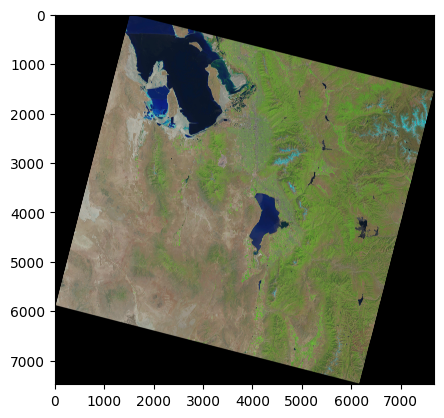

In [6]:
#show imge in the dataframe with plt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image):
    plt.imshow(mpimg.imread(image))
    plt.show()

show_image(image_paths[0])



